In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RUN_DIR = "./runs/fine_tune_20240409/"
FILE_EX = "/test/model_epoch010/test_results.p"
DIR_PATTERN = "finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_"

In [3]:
# Define your lists
site_ids = ["06614800", "06746095", "07083000", "09034900", "09035800", "09035900", "09047700", "09065500", "09066000", "09066200", "09066300", "09081600", "09107000", "09306242", "09352900"]
model_types = ["snotel", "noSWE"]
seeds = ["1", "2", "3", "4", "101", "102", "201", "202", "301", "302", "401", "402"]

In [11]:
# Initialize a dictionary to store your data
data_dict = {}

# Function to load a pickle file
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Iterate through site IDs, model types, and seeds

for model_type in model_types:
    if model_type not in data_dict:
        data_dict[model_type] = {}
    
    for site_id in site_ids:
        # Extract the xarray Dataset
        xr_dataset = pickle_data[site_id]['1D']['xr']
        data_dict[model_type][site_id] = {}

        for seed in seeds:
            # Generate the file name pattern
            file_pattern = f"{model_type}_seed{seed}"
        
            # Find all files matching the pattern
            for filename in os.listdir(RUN_DIR):
                #if fnmatch.fnmatch(filename, file_pattern):
                if file_pattern in filename:
                    print("We have a match", filename, file_pattern)
                    file_path = os.path.join(RUN_DIR, filename)
                    # Load data from pickle file
                    pickle_data = load_pickle(f"{file_path}{FILE_EX}")
                        
                    # You can now access 'QObs(mm/d)_obs' and 'QObs(mm/d)_sim' from xr_dataset
                    # For example, to get 'QObs(mm/d)_obs' and 'QObs(mm/d)_sim':
                    qobs_obs = xr_dataset['QObs(mm/d)_obs']
                    qobs_sim = xr_dataset['QObs(mm/d)_sim']
                    
                    # Store the time series data in your dictionary
                    # Assuming seed is unique per model_type per site, hence directly assigning
                    data_dict[model_type][site_id][seed] = {
                        "QObs(mm/d)_obs": qobs_obs,
                        "QObs(mm/d)_sim": qobs_sim,
                        "NSE": pickle_data[site_id]['1D']['NSE']
                    }

# At this point, data_dict contains all the loaded data organized as required.
# You can now proceed to calculate metrics, perform ensemble analysis, and plot the data as needed.


We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed102_0904_164536 snotel_seed1
We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed101_0904_164435 snotel_seed1
We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed1_0804_154406_0904_164711 snotel_seed1
We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed202_0904_164948 snotel_seed2
We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed2_0804_170553_0904_165113 snotel_seed2
We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed201_0904_164824 snotel_seed2
We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed301_0904_165322 snotel_seed3
We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed3_0804_195033_0904_165548 snotel_seed3
We have a match finetune_pretrain_hs128_lossMSE_lr1e-3down_HA_snotel_seed302_0904_165427 snotel_seed3
We have a match finetune_pretrain_hs128_lossMSE_lr1e

In [12]:
data_dict

{'snotel': {'06614800': {'1': {'QObs(mm/d)_obs': <xarray.DataArray 'QObs(mm/d)_obs' (date: 1461, time_step: 1)>
    array([[0.33137488],
           [0.3191017 ],
           [0.3191017 ],
           ...,
           [1.6568743 ],
           [1.7796057 ],
           [1.8409715 ]], dtype=float32)
    Coordinates:
      * date       (date) datetime64[ns] 2010-10-01 2010-10-02 ... 2014-09-30
      * time_step  (time_step) int64 0,
    'QObs(mm/d)_sim': <xarray.DataArray 'QObs(mm/d)_sim' (date: 1461, time_step: 1)>
    array([[0.44740796],
           [0.4545796 ],
           [0.44787484],
           ...,
           [0.63350016],
           [0.88378835],
           [0.86079746]], dtype=float32)
    Coordinates:
      * date       (date) datetime64[ns] 2010-10-01 2010-10-02 ... 2014-09-30
      * time_step  (time_step) int64 0,
    'NSE': 0.8506619334220886},
   '2': {'QObs(mm/d)_obs': <xarray.DataArray 'QObs(mm/d)_obs' (date: 1461, time_step: 1)>
    array([[0.33137488],
           [0.3191017 

In [13]:
def calculate_nse(observed, simulated):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE) for properly aligned Series.
    
    Parameters:
    - observed: Pandas Series of observed data.
    - simulated: Pandas Series of simulated data.
    
    Returns:
    - NSE value.
    """
    # Ensure both inputs are Series and share a common DatetimeIndex
    if not isinstance(observed, pd.Series) or not isinstance(simulated, pd.Series):
        raise ValueError("Both observed and simulated must be pandas Series with a DatetimeIndex.")
    
    # Intersect indices to ensure alignment
    common_index = observed.index.intersection(simulated.index)
    observed_aligned = observed.loc[common_index].dropna()
    simulated_aligned = simulated.loc[common_index].dropna()

    if not observed_aligned.empty and not simulated_aligned.empty:
        mean_observed = observed_aligned.mean()
        numerator = ((observed_aligned - simulated_aligned) ** 2).sum()
        denominator = ((observed_aligned - mean_observed) ** 2).sum()
        nse = 1 - (numerator / denominator)
        return nse
    else:
        return np.nan  # Indicate misalignment or empty data


In [39]:
def plot_site_time_series_multi_model_nse(data_dict, site_id):
    """
    Plot the time series for an individual site with NSE values for multiple models.
    
    Parameters:
    - data_dict: Dictionary containing the data.
    - site_id: Site ID to plot.
    """
    plt.figure(figsize=(6, 4))

    # Initial vertical position for the first NSE annotation
    vertical_position = 0.95
    
    # Vertical offset to stack annotations
    vertical_offset = 0.1
    
    model_colors = {
        'noSWE': ('pink', 'darkred'),
        'snotel': ('lightsteelblue', 'blue')
    }
    model_style = {
        'noSWE': "-",
        'snotel': "--"
    }
    # Iterate through model types and plot each
    for model_type in ['noSWE', 'snotel']:
        ensemble_sim_data = []
        for seed, data in data_dict[model_type][site_id].items():
            qobs_obs = data['QObs(mm/d)_obs'].to_pandas()
            qobs_sim = data['QObs(mm/d)_sim'].to_pandas()
            plt.plot(qobs_sim.index, qobs_sim, 
                     color=model_colors[model_type][0], linewidth=0.5, ls=model_style[model_type])
            ensemble_sim_data.append(qobs_sim)
            
        ensemble_mean = pd.concat(ensemble_sim_data, axis=1).mean(axis=1)
        plt.plot(ensemble_mean.index, ensemble_mean, color=model_colors[model_type][1], 
                 label=f'{model_type}', linewidth=2, ls=model_style[model_type])

        # Calculate NSE for the ensemble mean and adjust text placement
        # Given qobs_obs structure, directly using the single unnamed column for observed data
        qobs_obs_series = qobs_obs[0]
        nse_value = calculate_nse(qobs_obs_series, ensemble_mean)
        plt.text(0.05, vertical_position, f'{model_type} NSE: {nse_value:.2f}', 
                 transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Update vertical_position for the next annotation
        vertical_position -= vertical_offset

    plt.plot(qobs_obs.index, qobs_obs, color='black', label='Observed', linewidth=1.5)
    plt.title(f'Time Series for Site {site_id}')
    plt.xlabel('Date')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('QObs (mm/d)')
    plt.legend()
    plt.tight_layout()
    plt.show()


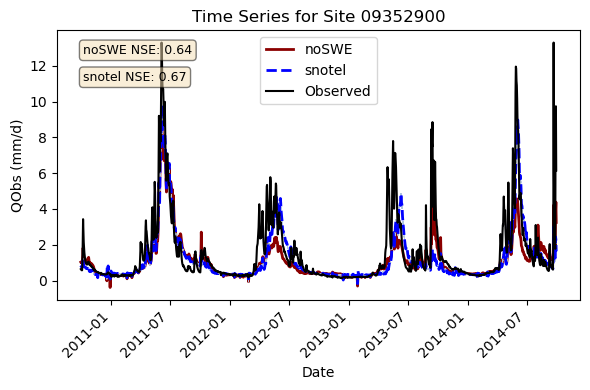

In [40]:
# Example usage
# Assuming 'data_dict' is already filled with your data
plot_site_time_series_multi_model_nse(data_dict, '09352900')

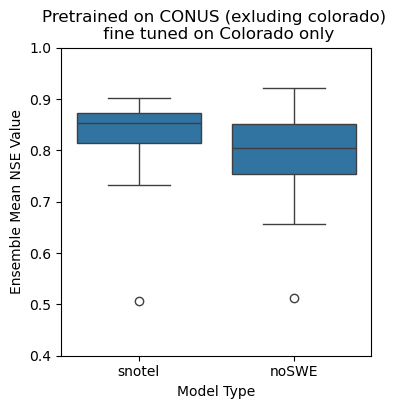

In [32]:
# Step 1: Aggregate NSE Values and Calculate Ensemble Mean
ensemble_mean_nse = {'Model': [], 'Ensemble Mean NSE': []}
for model_type, sites in data_dict.items():
    for site_id, seeds in sites.items():
        # Skip specific site_id if necessary
        if site_id == "09306242":
            continue
        # Aggregate NSE values for each site
        nse_values_site = [results['NSE'] for seed, results in seeds.items()]
        # Calculate mean NSE for the site
        mean_nse_site = sum(nse_values_site) / len(nse_values_site)
        # Append the mean NSE to the list
        ensemble_mean_nse['Model'].append(model_type)
        ensemble_mean_nse['Ensemble Mean NSE'].append(mean_nse_site)

# Step 2: Prepare the Data for Plotting
ensemble_mean_nse_df = pd.DataFrame(ensemble_mean_nse)

# Step 3: Create Box Plots
plt.figure(figsize=(4, 4))
sns.boxplot(x='Model', y='Ensemble Mean NSE', data=ensemble_mean_nse_df)

plt.title('Pretrained on CONUS (exluding colorado) \n fine tuned on Colorado only')
plt.xlabel('Model Type')
plt.ylabel('Ensemble Mean NSE Value')
plt.ylim(0.4, 1)  # Adjust the Y-axis limits as necessary

plt.show()

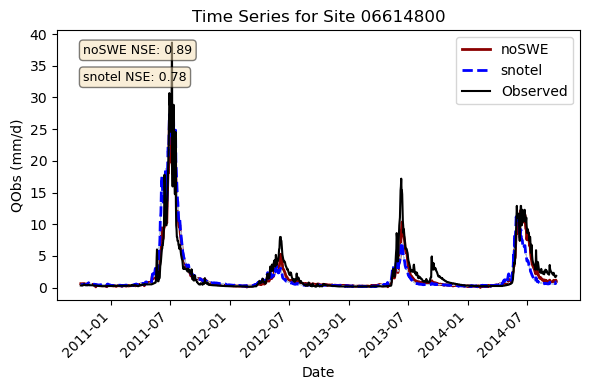

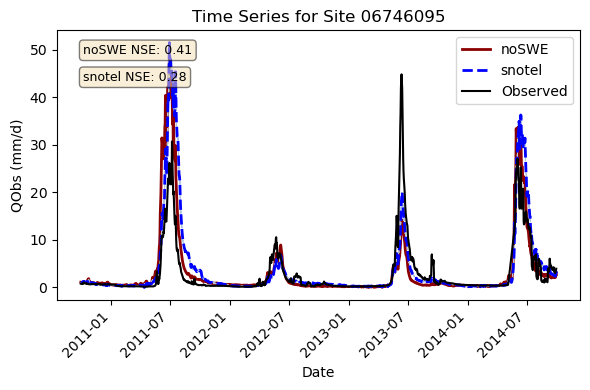

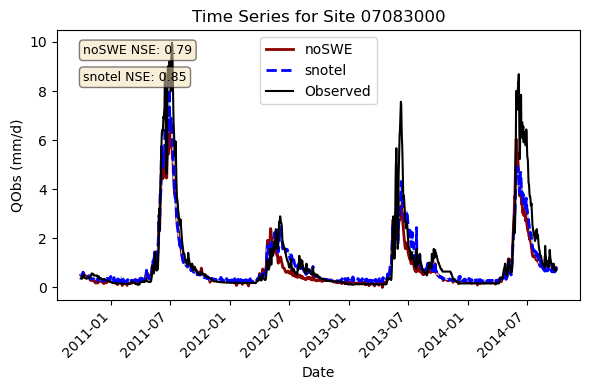

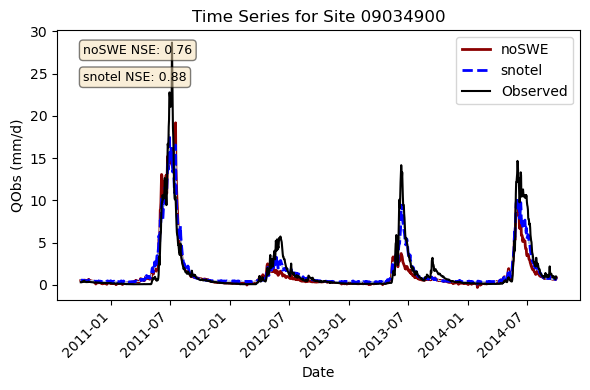

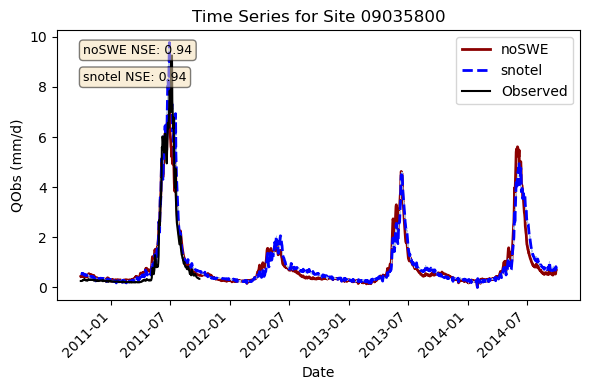

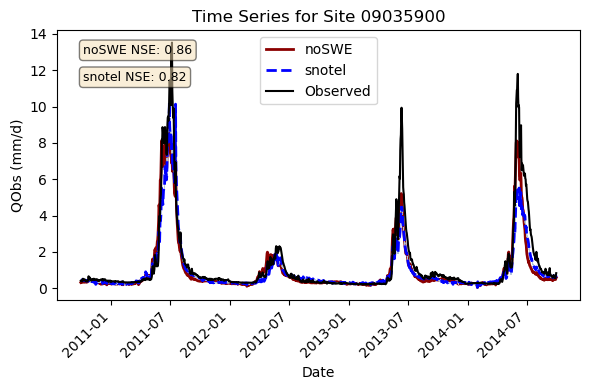

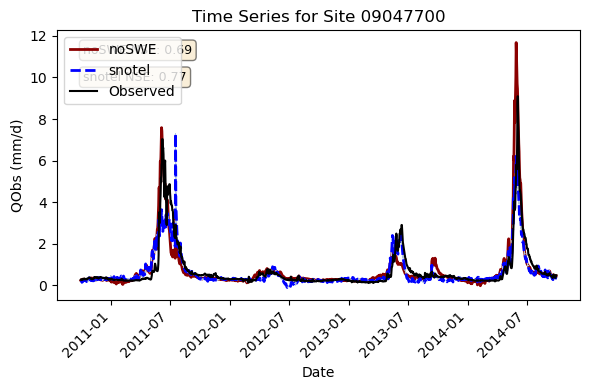

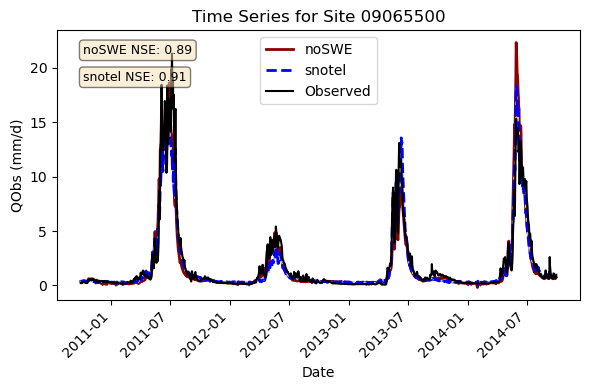

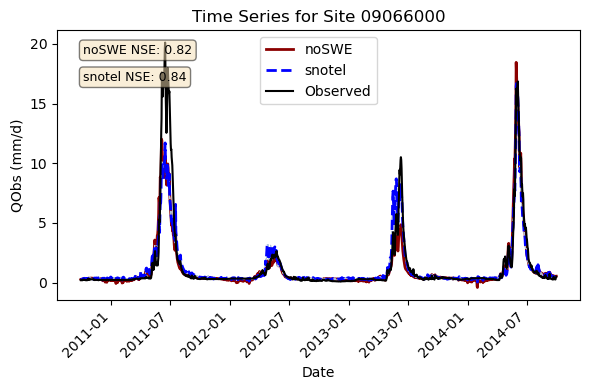

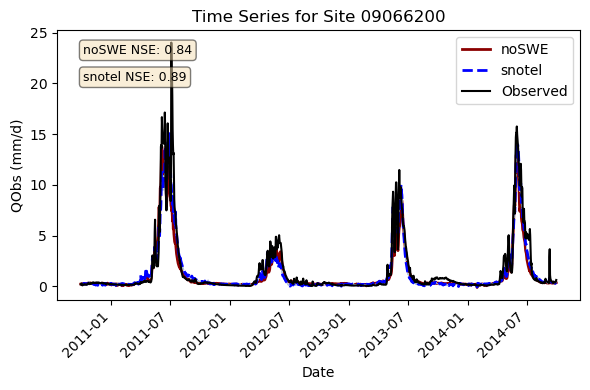

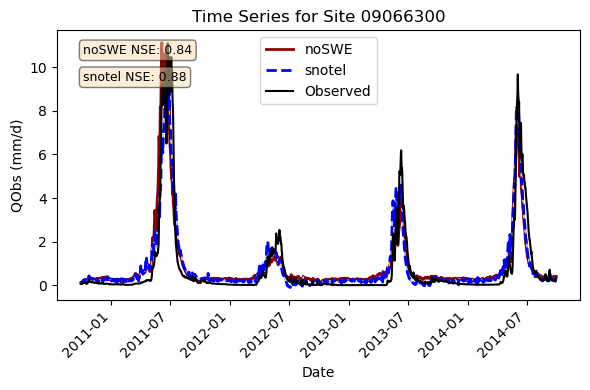

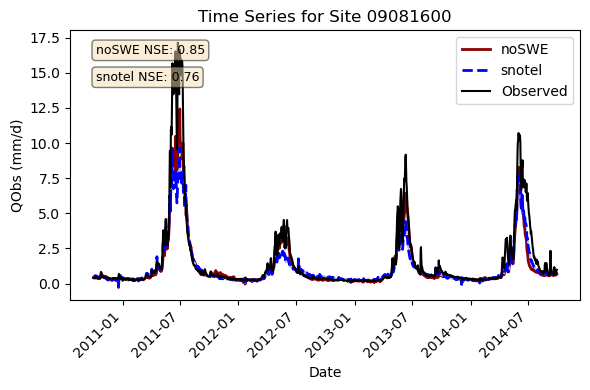

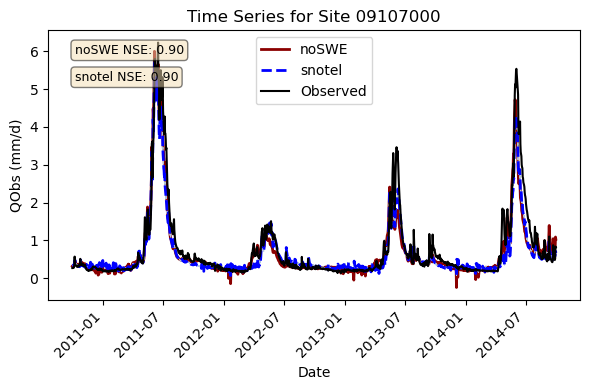

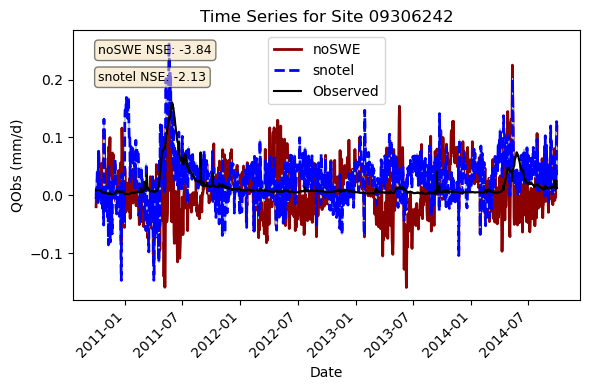

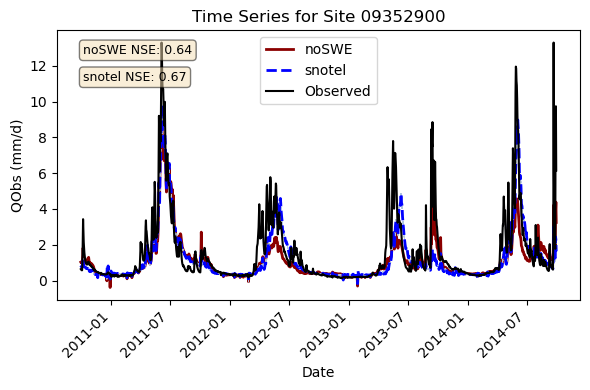

In [41]:
for site_id in site_ids:
    plot_site_time_series_multi_model_nse(data_dict, site_id)